<a href="https://colab.research.google.com/github/sp7412/colab/blob/master/distilling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!nvidia-smi

Thu Aug  6 16:36:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |    227MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [6]:
GPUs = tf.config.experimental.list_physical_devices('GPU')
# get list of GPUs on host
if GPUs:
    print("Tensorflow detected GPUs")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(GPUs), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print("Memory growth must be set before GPUs have been initialized")
        print(e)

Tensorflow detected GPUs
1 Physical GPUs, 1 Logical GPUs


In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def softmax_sparse_categorical_crossentropy(labels, logits):
  softmaxed = tf.keras.backend.softmax(logits)

  return tf.keras.losses.sparse_categorical_crossentropy(labels, softmaxed)

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [9]:
num_classes = ds_info.features['label'].num_classes

In [10]:
ds_info.features['image'].shape

(28, 28, 1)

In [11]:
num_training_examples = ds_info.splits['train'].num_examples
num_training_examples

60000

In [12]:
ds_train_iter = ds_train.as_numpy_iterator()
train_images, train_labels = zip(*[ds_train_iter.next() for i in range(num_training_examples)])
train_images = np.asarray(train_images)

In [13]:
# labels are integers so we need to use sparse_categorical_crossentropy instead of categorical_crossentropy
train_labels[:2]

(1, 4)

Text(0.5, 1.0, '6')

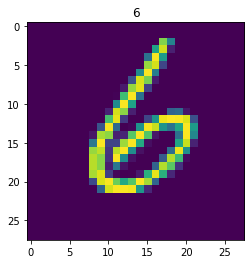

In [14]:
import matplotlib.pyplot as plt
idx = 10
plt.imshow(np.squeeze(train_images[idx]))
plt.title(train_labels[idx])

In [15]:
train_images.shape

(60000, 28, 28, 1)

In [16]:
num_testing_examples = ds_info.splits['test'].num_examples
num_testing_examples

10000

In [17]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
ds_test_iter = ds_test.as_numpy_iterator()

In [19]:
test_images, test_labels = zip(*[ds_test_iter.next() for i in range(num_testing_examples)])

In [20]:
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
control_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  tf.keras.layers.Dense(10, activation='softmax')])
  # tf.keras.layers.Dense(10, activation=None)])

control_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
# control_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
# control_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
control_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0

In [22]:
control_model.fit(train_images,np.asarray(train_labels), epochs=30,validation_split=0.2)

Epoch 1/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.7514 - accuracy: 0.7907 - val_loss: 0.3425 - val_accuracy: 0.9162
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3073 - accuracy: 0.9125 - val_loss: 0.2017 - val_accuracy: 0.9430
Epoch 3/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2432 - accuracy: 0.9287 - val_loss: 0.2164 - val_accuracy: 0.9387
Epoch 4/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2172 - accuracy: 0.9349 - val_loss: 0.1802 - val_accuracy: 0.9473
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1962 - accuracy: 0.9392 - val_loss: 0.1452 - val_accuracy: 0.9581
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1805 - accuracy: 0.9436 - val_loss: 0.1316 - val_accuracy: 0.9594
Epoch 7/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1769 - accuracy: 0.9455 - val_loss: 0.1279 - val_accuracy:

In [23]:
test_loss, test_acc = control_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 2s 20ms/step - loss: 0.0941 - accuracy: 0.9720
Test Loss: 0.09408590197563171
Test Accuracy: 0.972000002861023


In [24]:
test_loss, test_acc = control_model.evaluate(np.asarray(test_images),np.asarray(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9720
Test Loss: 0.09408590197563171
Test Accuracy: 0.972000002861023


In [33]:
teacher_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  #tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

# teacher_model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy']) # awful
teacher_model.compile('adam', softmax_sparse_categorical_crossentropy, ['accuracy'])
teacher_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 64)         

In [34]:
teacher_model.fit(ds_train, epochs=40)

Epoch 1/40
469/469 [==============================] - 2s 4ms/step - loss: 0.3914 - accuracy: 0.8919
Epoch 2/40
469/469 [==============================] - 2s 4ms/step - loss: 0.1239 - accuracy: 0.9647
Epoch 3/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0910 - accuracy: 0.9738
Epoch 4/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0740 - accuracy: 0.9780
Epoch 5/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0653 - accuracy: 0.9796
Epoch 6/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0570 - accuracy: 0.9823
Epoch 7/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0534 - accuracy: 0.9831
Epoch 8/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0479 - accuracy: 0.9851
Epoch 9/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0443 - accuracy: 0.9862
Epoch 10/40
469/469 [==============================] - 2s 4ms/step - loss: 0.0417 - accuracy: 0.9870

In [35]:
test_loss, test_acc = teacher_model.evaluate(ds_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.9920
Test Loss: 0.03371615707874298
Test Accuracy: 0.9919999837875366


In [36]:
ds_train_images = tf.data.Dataset.from_tensor_slices(list(map(lambda x:tf.reshape(x,(-1,28,28,1)), train_images)))
soft_labels_train = teacher_model.predict(train_images,verbose=1)

1875/1875 [==============================] - 2s 1ms/step


In [37]:
soft_labels_train

array([[-1.2264347 , 15.056972  , -0.11227764, ...,  4.4578333 ,
        -1.6349523 , -5.492013  ],
       [-3.9570134 ,  3.8842561 , -3.2265153 , ...,  3.0931685 ,
         0.63524705,  1.7789557 ],
       [-0.02634468, -2.8005726 ,  3.752659  , ..., 19.79496   ,
        -4.237766  , -1.8213347 ],
       ...,
       [ 5.167602  , -1.0719528 ,  0.8606929 , ..., -8.203195  ,
        -2.1975727 , -3.6170924 ],
       [-2.7675464 , 16.637905  , -2.6154883 , ...,  1.4350276 ,
        -0.34115666, -1.5480031 ],
       [-9.11051   , -7.547922  , -9.361275  , ..., -8.520095  ,
         7.4954658 , -0.9133364 ]], dtype=float32)

In [38]:
temperature = 3
afterwards_temperature = 1

def temperature_softmax(logits):
  soft_logits = tf.keras.backend.exp(logits / temperature)
  return soft_logits / tf.keras.backend.sum(soft_logits, axis=-1, keepdims=True) / afterwards_temperature

def distillation_loss(labels, logits):
  labels = temperature_softmax(labels)
  logits = temperature_softmax(logits)

  return -tf.keras.backend.mean(labels * tf.keras.backend.log(logits))

In [39]:
student_model = tf.keras.models.Sequential([
  tf.keras.Input([28, 28]), 
  tf.keras.layers.Reshape([28, 28, 1]), 
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, 2, activation='relu'), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(), 
  # tf.keras.layers.Dense(10, activation='softmax')])
  tf.keras.layers.Dense(10, activation=None)])

student_model.compile('adam', distillation_loss, ['accuracy'])
student_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 64)         

In [40]:
student_model.fit(train_images, soft_labels_train, epochs=100, validation_split=0.2)

Epoch 1/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1116 - accuracy: 0.7215 - val_loss: 0.0688 - val_accuracy: 0.8506
Epoch 2/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0544 - accuracy: 0.9003 - val_loss: 0.0433 - val_accuracy: 0.9366
Epoch 3/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0455 - accuracy: 0.9242 - val_loss: 0.0392 - val_accuracy: 0.9463
Epoch 4/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0424 - accuracy: 0.9333 - val_loss: 0.0376 - val_accuracy: 0.9517
Epoch 5/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0405 - accuracy: 0.9398 - val_loss: 0.0358 - val_accuracy: 0.9551
Epoch 6/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0398 - accuracy: 0.9433 - val_loss: 0.0343 - val_accuracy: 0.9617
Epoch 7/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0388 - accuracy: 0.9473 - val_loss: 0.0344 - val_ac

temperature = 1 > loss: 0.0106 - accuracy: 0.9670 - val_loss: 0.0084 - val_accuracy: 0.9753

temperature = 3 > loss: 0.0350 - accuracy: 0.9672 - val_loss: 0.0321 - val_accuracy: 0.9725

temperature = 5 > loss: 0.0967 - accuracy: 0.9610 - val_loss: 0.0930 - val_accuracy: 0.9697

temperature = 7 > loss: 0.1481 - accuracy: 0.9581 - val_loss: 0.1462 - val_accuracy: 0.9645

In [43]:
assert student_model.layers[-1].activation == tf.keras.activations.linear
config = student_model.layers[-1].get_config()

In [48]:
config['activation'] = tf.keras.activations.softmax

In [46]:
weights = [x.numpy() for x in student_model.layers[-1].weights]

In [49]:
new_layer = tf.keras.layers.Dense(**config)(student_model.layers[-2].output)
new_model = tf.keras.Model(inputs=[student_model.input], outputs=[new_layer])
new_model.layers[-1].set_weights(weights)

assert new_model.layers[-1].activation == tf.keras.activations.softmax

In [50]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [51]:
test_loss, test_acc = new_model.evaluate(ds_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.9780
Test Loss: 0.0819755271077156
Test Accuracy: 0.9779999852180481


In [52]:
# from https://stackoverflow.com/a/58547262/5495698
student_model.layers[-1].activation = tf.keras.activations.softmax

In [53]:
student_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [59]:
student_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
dropout_24 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_25 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
dropout_25 (Dropout)         (None, 6, 6, 64)        

In [54]:
test_loss, test_acc = student_model.evaluate(ds_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

79/79 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.9780
Test Loss: 0.0819755271077156
Test Accuracy: 0.9779999852180481


In [62]:
test_loss, test_acc = student_model.evaluate(np.asarray(test_images),np.asarray(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1116 - accuracy: 0.9726
Test Loss: 0.11164768040180206
Test Accuracy: 0.972599983215332
